<a href="https://colab.research.google.com/github/AKASH4671/AI-Powered-Portfolio-Optimization-and-Risk-Management/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**libraries**

In [17]:
!pip install yfinance --quiet
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

**mount google drive**

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Set path to saved CSVs & load**

In [12]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Powered-Portfolio-Optimization-and-Risk-Management/data/'

# Load the 3 saved portfolio CSVs
equal_df = pd.read_csv(save_path + 'portfolio_equal_weight.csv')
diverse_df = pd.read_csv(save_path + 'portfolio_cluster_diversified.csv')
pca_df = pd.read_csv(save_path + 'portfolio_pca_weighted.csv')

# Combine all tickers to download full price history (avoid duplicates)
tickers = pd.concat([equal_df['Ticker'], diverse_df['Ticker'], pca_df['Ticker']]).unique().tolist()

print("Tickers to download:", tickers)

# Download last 3 years of data (you can adjust the period)
data = yf.download(tickers, start="2022-01-01", end="2025-07-17", auto_adjust=False)

# Add a check to ensure data is not empty
if not data.empty:
    # Extract 'Adj Close' prices for all tickers into a new DataFrame
    price_data = pd.DataFrame(data['Adj Close'])

    # Preview data
    display(price_data.tail())
else:
    print("Data download failed or returned empty data.")


print("\nType of data:", type(data))
print("Data structure (first few rows):\n", data.head())

[**********            20%                       ]  2 of 10 completed

Tickers to download: ['MSFT', 'AAPL', 'GOOGL', 'AMZN', 'NVDA', 'JPM', 'TSLA', 'WMT', 'JNJ', 'XOM']


[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,NVDA,TSLA,WMT,XOM
Date,,,,,,,,,,
2025-07-10,212.410004,222.259995,177.619995,157.690002,288.190002,501.480011,164.100006,309.869995,94.860001,114.930000
2025-07-11,211.160004,225.020004,180.190002,156.899994,286.859985,503.320007,164.919998,313.510010,94.400002,115.430000
2025-07-14,208.619995,225.690002,181.559998,156.820007,288.700012,503.019989,164.070007,316.899994,95.779999,113.919998
2025-07-15,209.110001,226.350006,182.000000,155.169998,286.549988,505.820007,170.699997,310.779999,95.389999,112.910004
2025-07-16,210.160004,223.190002,182.970001,164.779999,285.820007,505.619995,171.369995,321.670013,95.150002,112.230003



Type of data: <class 'pandas.core.frame.DataFrame'>
Data structure (first few rows):
 Price        Adj Close                                                  \
Ticker            AAPL        AMZN       GOOGL         JNJ         JPM   
Date                                                                     
2022-01-03  178.645660  170.404495  144.127121  154.672607  146.291061   
2022-01-04  176.378342  167.522003  143.538666  154.257874  151.836899   
2022-01-05  171.686691  164.356995  136.953629  155.285782  149.060989   
2022-01-06  168.820663  163.253998  136.926315  154.753799  150.644638   
2022-01-07  168.987518  162.554001  136.200165  156.845673  152.137222   

Price                                                                ...  \
Ticker            MSFT       NVDA        TSLA        WMT        XOM  ...   
Date                                                                 ...   
2022-01-03  325.038055  30.066132  399.926666  45.965813  56.124836  ...   
2022-01-04  319.

**Compute Daily Portfolio Returns**

In [13]:
# Ensure price_data is clean
price_data = price_data.dropna()

# Calculate daily returns
daily_returns = price_data.pct_change().dropna()

# --- 1️. Equal Weighted Portfolio Returns ---
equal_weights = equal_df.set_index('Ticker')['Weight']
equal_returns = daily_returns[equal_weights.index].dot(equal_weights)

# --- 2️. Cluster Diversified Portfolio Returns ---
diverse_weights = diverse_df.set_index('Ticker')['Weight']
diverse_returns = daily_returns[diverse_weights.index].dot(diverse_weights)

# --- 3️. PCA Weighted Portfolio Returns ---
pca_weights = pca_df.set_index('Ticker')['Weight']
pca_returns = daily_returns[pca_weights.index].dot(pca_weights)

# Combine all 3 return series into a single DataFrame
portfolio_returns = pd.DataFrame({
    'Equal_Weighted': equal_returns,
    'Cluster_Diversified': diverse_returns,
    'PCA_Weighted': pca_returns
})

# Preview the result
display(portfolio_returns.tail())


,Equal_Weighted,Cluster_Diversified,PCA_Weighted
Date,,,
2025-07-10,0.007773,-0.000333,0.007176
2025-07-11,0.003129,0.002450,0.003683
2025-07-14,0.001106,-0.002211,0.000772
2025-07-15,0.000345,0.006385,0.002286
2025-07-16,0.008581,-0.002325,0.006706


**Part A: Plot Cumulative Returns of All Portfolios**

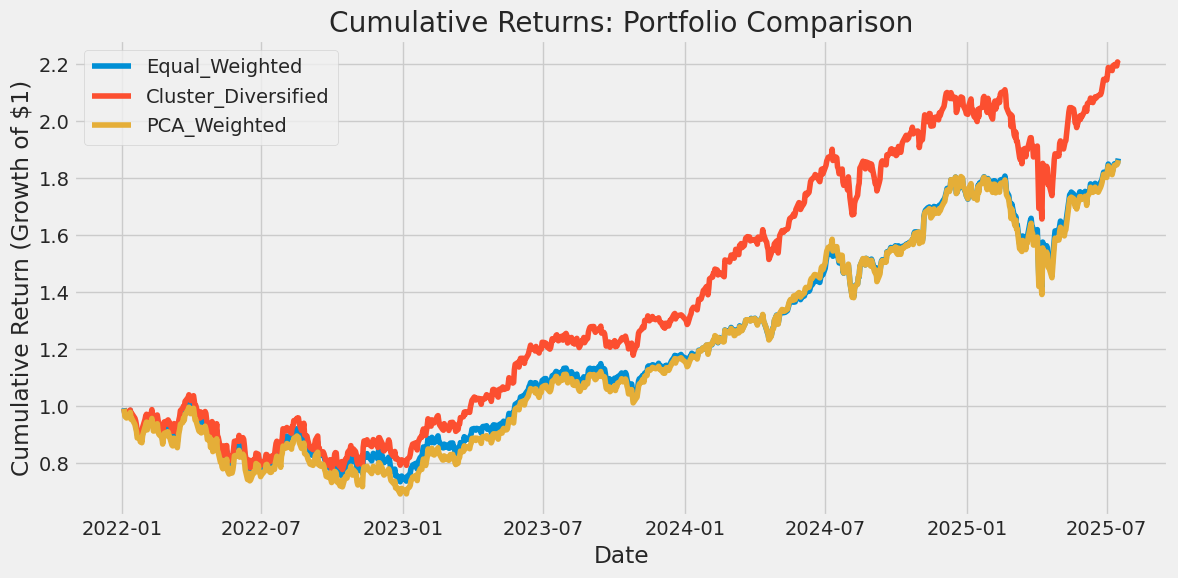

In [14]:
# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plotting
plt.figure(figsize=(12, 6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title('Cumulative Returns: Portfolio Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Growth of $1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Part B: Step 1: Prepare Time Series Data for LSTM**

In [16]:
# Function to prepare sequences for LSTM
def create_lstm_dataset(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# Dictionary to hold LSTM datasets for each portfolio
lstm_datasets = {}

# Scale and prepare dataset for each portfolio
scalers = {}

for column in portfolio_returns.columns:
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(portfolio_returns[[column]])

    X, y = create_lstm_dataset(scaled_series.flatten(), window_size=30)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Required input shape for LSTM: (samples, timesteps, features)

    # Save
    lstm_datasets[column] = (X, y)
    scalers[column] = scaler

print("LSTM datasets prepared for all portfolios.")


LSTM datasets prepared for all portfolios.


**Part B: Step 2: Build & Train LSTM for Each Portfolio**

In [19]:
# Dictionary to hold results
predictions = {}

for name, (X, y) in lstm_datasets.items():
    print(f"\n Training LSTM for portfolio: {name}")

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Build model
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

    # Predict next-day return (last sequence in X)
    last_sequence = X[-1].reshape(1, 30, 1)
    next_day_scaled = model.predict(last_sequence)[0][0]

    # Inverse transform to get real return
    next_day_real = scalers[name].inverse_transform([[next_day_scaled]])[0][0]

    # Actual last return (for comparison)
    actual_return = scalers[name].inverse_transform([[y[-1]]])[0][0]

    # Save result
    predictions[name] = {
        "Predicted_Next_Day_Return": next_day_real,
        "Actual_Last_Return": actual_return
    }

    print(f" {name} | Predicted Return: {next_day_real:.5f}, Actual Last Return: {actual_return:.5f}")



 Training LSTM for portfolio: Equal_Weighted


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
 Equal_Weighted | Predicted Return: -0.00060, Actual Last Return: 0.00858

 Training LSTM for portfolio: Cluster_Diversified


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Cluster_Diversified | Predicted Return: 0.00168, Actual Last Return: -0.00232

 Training LSTM for portfolio: PCA_Weighted


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
 PCA_Weighted | Predicted Return: 0.00179, Actual Last Return: 0.00671


**Compare Portfolio Performance Using LSTM Prediction**


 Portfolio Prediction Summary:


,Portfolio,Predicted_Next_Day_Return,Actual_Last_Return
2,PCA_Weighted,0.001792,0.006706
1,Cluster_Diversified,0.001679,-0.002325
0,Equal_Weighted,-0.000600,0.008581


/tmp/ipython-input-20-703388364.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Portfolio', y='Predicted_Next_Day_Return', palette='viridis')


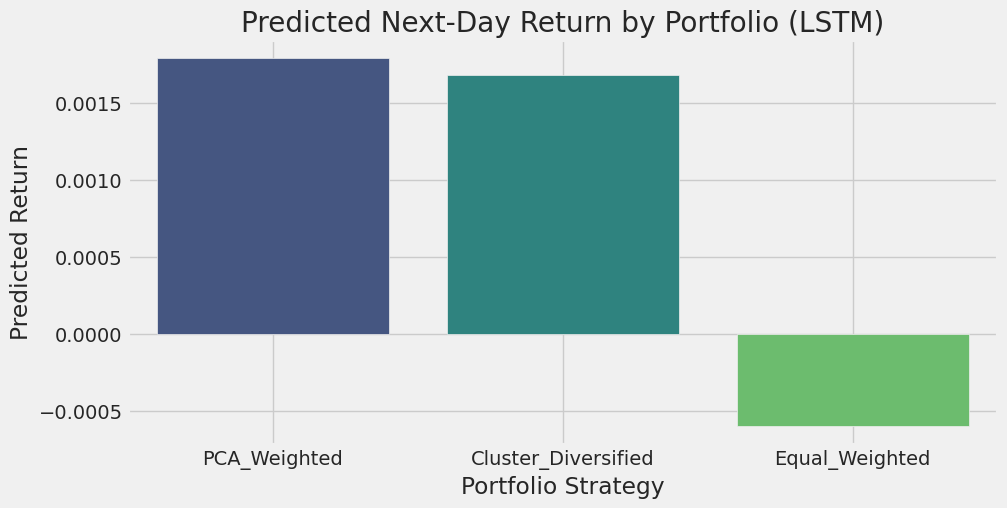

In [20]:
# Convert prediction results to a clean DataFrame
results_df = pd.DataFrame(predictions).T.reset_index()
results_df.columns = ['Portfolio', 'Predicted_Next_Day_Return', 'Actual_Last_Return']

# Sort by predicted return (descending)
results_df = results_df.sort_values(by='Predicted_Next_Day_Return', ascending=False)

# Display results
print("\n Portfolio Prediction Summary:")
display(results_df)

# Bar chart of predicted returns
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Portfolio', y='Predicted_Next_Day_Return', palette='viridis')
plt.title("Predicted Next-Day Return by Portfolio (LSTM)")
plt.ylabel("Predicted Return")
plt.xlabel("Portfolio Strategy")
plt.grid(True)
plt.show()


**Predicted vs Actual**

,Portfolio,Predicted_Return,Actual_Return,Error,Absolute_Error,Direction_Match
0,Equal_Weighted,-0.000600,0.008581,-0.009181,0.009181,False
1,Cluster_Diversified,0.001679,-0.002325,0.004004,0.004004,False
2,PCA_Weighted,0.001792,0.006706,-0.004914,0.004914,True


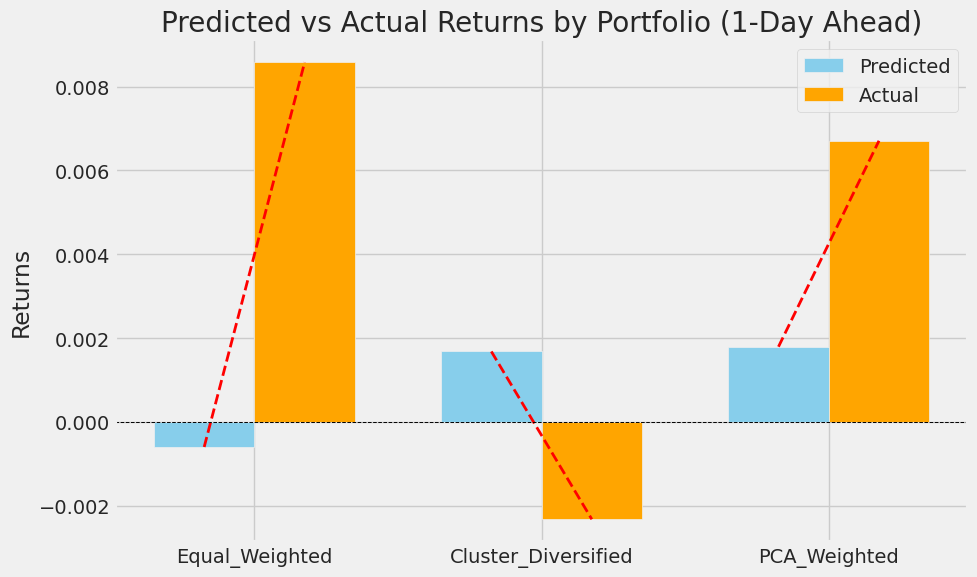

Prediction error log saved.


In [23]:
# Create a dataframe with prediction vs actual
summary_df = pd.DataFrame({
    'Portfolio': ['Equal_Weighted', 'Cluster_Diversified', 'PCA_Weighted'],
    'Predicted_Return': [-0.0006, 0.001679, 0.001792],
    'Actual_Return': [0.008581, -0.002325, 0.006706]
})

# Calculate error metrics
summary_df['Error'] = summary_df['Predicted_Return'] - summary_df['Actual_Return']
summary_df['Absolute_Error'] = summary_df['Error'].abs()
summary_df['Direction_Match'] = (summary_df['Predicted_Return'] * summary_df['Actual_Return']) > 0

# Preview
display(summary_df)

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(summary_df))

# Bar plot: Predicted vs Actual returns
plt.bar(x, summary_df['Predicted_Return'], width=bar_width, label='Predicted', color='skyblue')
plt.bar([i + bar_width for i in x], summary_df['Actual_Return'], width=bar_width, label='Actual', color='orange')

# Error lines (visual uncertainty)
for i in x:
    plt.plot([i, i + bar_width], [summary_df.loc[i, 'Predicted_Return'], summary_df.loc[i, 'Actual_Return']],
             color='red', linestyle='--', linewidth=2)

# Labels & legends
plt.xticks([i + bar_width/2 for i in x], summary_df['Portfolio'])
plt.ylabel('Returns')
plt.title('Predicted vs Actual Returns by Portfolio (1-Day Ahead)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Save error log to Drive
import os
save_path = '/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Powered-Portfolio-Optimization-and-Risk-Management/logs/'
# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)
summary_df.to_csv(save_path + 'portfolio_prediction_error_log.csv', index=False)
print("Prediction error log saved.")